# Home assignment 3

### Name & Student No.:
- Abdel Kader, Schehat & 10064822
- Tarbouch, Johny & 10033994

# 1. Data Loading & Preprocessing

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, Dataset
import matplotlib.pyplot as plt
import numpy as np

import time
from torch.utils.data import random_split

In [3]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
# transform images to tensors
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
# Load & transform CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


## Data Exploration

In [6]:
image, label = trainset[0]

# Explore dataset
print(f"Number of samples in the training dataset: {len(trainset)}")
print(f"Shape chanels, hight, width: {image.shape}")
print(f"Label: {label}")
classes = trainset.classes
print(f"Classes: {classes}")

# Explore image
print(f"Image Type: {type(image)}")
print(f"Image Size: {image.shape}")
print(f"Image Data Type: {image.dtype}")

Number of samples in the training dataset: 50000
Shape chanels, hight, width: torch.Size([3, 32, 32])
Label: 6
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image Type: <class 'torch.Tensor'>
Image Size: torch.Size([3, 32, 32])
Image Data Type: torch.float32


## Ploting Images
- Selects one image per class from a training dataset and displays them in a single row of subplots.

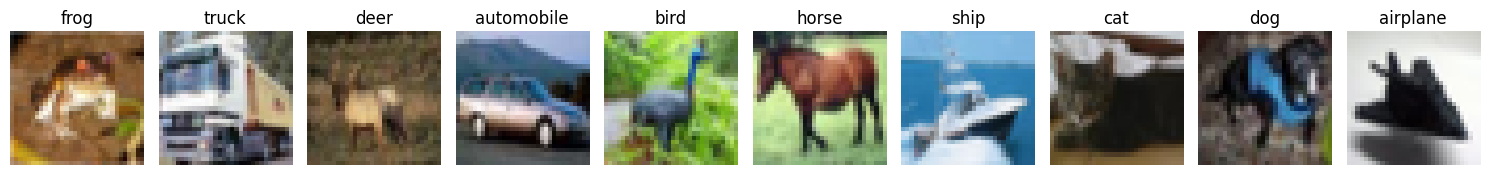

In [7]:
# dict to store one image per class
samples = {}

# Find one image per class
for image, label in trainset:
    if label not in samples: 
        samples[label] = image
    if len(samples) == len(class_names):
        break

fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5)) 

# plot one image per class
for idx, (label, img) in enumerate(samples.items()):
    img = img.permute(1, 2, 0)
    axes[idx].imshow(img)
    axes[idx].set_title(class_names[label]) 
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Extract cats and dogs from the training/testing data

In [10]:
def extract_cats_and_dogs(dataset):

    cats_dogs_train = []
    other_classes_train = []
    # iterate over the dataset and extract images of cats and dogs
    for image, label in dataset:
        if label == 3:  # cat
            cats_dogs_train.append((image, 0))
        elif label == 5:  # dog
            cats_dogs_train.append((image, 1))
        else:
            other_classes_train.append((image, label))

    return cats_dogs_train, other_classes_train

cats_dogs_train, other_classes_train = extract_cats_and_dogs(trainset)
cats_dogs_test, other_classes_test = extract_cats_and_dogs(testset)

## Create DataLoader

In [11]:
class SimpleDataset(Dataset): 
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_cats_dogs = SimpleDataset(cats_dogs_train) 
test_cats_dogs = SimpleDataset(cats_dogs_test)
train_other_classes = SimpleDataset(other_classes_train)
test_other_classes = SimpleDataset(other_classes_train)

 # data loaders for cats and dogs only, and one for the other classes 
train_loader_cats_dogs = DataLoader(train_cats_dogs, batch_size=64, shuffle=True)
test_loader_cats_dogs = DataLoader(test_cats_dogs, batch_size=64, shuffle=False) 
other_train_loader = DataLoader(train_other_classes, batch_size=64, shuffle=True)
other_test_loader = DataLoader(test_other_classes, batch_size=64, shuffle=True)

In [12]:
print(f"Training dataset length: {len(train_cats_dogs)}")
print(f"Testing dataset length: {len(test_cats_dogs)}")

Training dataset length: 10000
Testing dataset length: 2000


# 2. CNN to discriminate cats and dogs
**Task 1:** Train a CNN to discriminate cats and dogs using CIFAR-10 data

Design Decision:
- Small architecture to prevent overfitting because dataset is small
- CNN consists of 2 Conv2d layers followed by ReLU and max-pooling
- FNN at the end for classification of the 2 classes, cat or dog
- Note: We tried different architectures but the implemented BasicCNN had the best results
  - Tried different numbers/parameters of the CNN
  - Tried 1 and 3 layers in the FNN and/or 1 output value for binary classification and with BCEWithLogitsLoss 

In [13]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Input: (batch_size, 3, 32, 32)
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  
            # Output: (batch_size, 32, 32, 32)
            
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            # Output: (batch_size, 32, 16, 16)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  
            # Output: (batch_size, 64, 16, 16)
            
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            # Output: (batch_size, 64, 8, 8)
        )

        self.classifier = nn.Sequential(
            # Input: (batch_size, 64, 8, 8)
            nn.Flatten(), 
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

## Train BasicCNN

In [14]:
def train_model(model, dataloader, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
    
            optimizer.zero_grad()
    
            outputs = model(inputs)
            loss = criterion(outputs, labels)
    
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
            # Track accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(dataloader)}, Accuracy: {100 * correct / total}%')

## CNN Evaluation

In [15]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # get the predicted class
            _, predicted = torch.max(outputs, 1)
            
            # update the total count
            total += labels.size(0)
            # update the correct count
            correct += (predicted == labels).sum().item() # update the correct count
    
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

**Observation:**
- Got better and consistent better results when stopping after 10 epochs because afterward it will overfit
- With multiple runs, average accuracy in the testing set is at around 76% with a difference of +- 1%

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = BasicCNN().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(cnn.parameters(), lr=0.001) 

print("Training CNN...")
train_model(cnn, train_loader_cats_dogs, criterion, optimizer, epochs=10, device=device)
print()
print("Evaluating CNN...")
evaluate_model(cnn, test_loader_cats_dogs, device=device)

Training CNN...
Epoch 1/10, Loss: 0.6550242395917322, Accuracy: 61.22%
Epoch 2/10, Loss: 0.5877092038370242, Accuracy: 68.74%
Epoch 3/10, Loss: 0.556934939638065, Accuracy: 72.18%
Epoch 4/10, Loss: 0.5267985075902027, Accuracy: 73.44%
Epoch 5/10, Loss: 0.5028870703688093, Accuracy: 75.2%
Epoch 6/10, Loss: 0.48307174975705, Accuracy: 76.56%
Epoch 7/10, Loss: 0.4634007361664134, Accuracy: 77.62%
Epoch 8/10, Loss: 0.44127826591965497, Accuracy: 79.0%
Epoch 9/10, Loss: 0.41715360219311565, Accuracy: 80.8%
Epoch 10/10, Loss: 0.39150011340144336, Accuracy: 82.47%

Evaluating CNN...
Accuracy: 75.55%


75.55

# 3. Denoising autoencoder

**Task 2:** Pre-train a denoising autoencoder on images from CIFAR-10 (except for cats and dogs)

## Show denoising samples

In [29]:
def add_noise(image, noise_factor):
    image = image.to(device)
    # Adds Gaussian noise to an image.
    noisy_images = image + noise_factor * torch.randn_like(image).to(device)
    # noisy image tensor with values clipped between 0 and 1.
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images

image, _ = next(iter(other_train_loader))
noisy_images = add_noise(image, 0.3)

## Example of image with 10 noises between 0.01 and 0.5

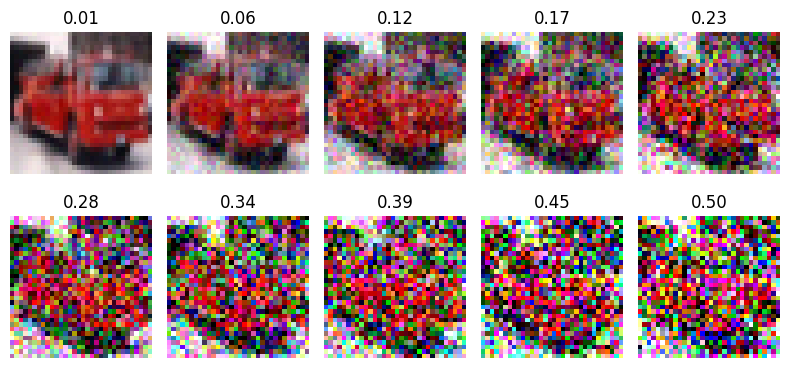

In [30]:
plt.figure(figsize=(8, 4))
for i, noise_fac in enumerate(np.linspace(0.01, 0.5, 10)):
    noisy_images = add_noise(image, noise_factor=noise_fac)
    plt.subplot(2, 5, i + 1)
    # display the image with the shape (H, W, C)
    plt.imshow(noisy_images[0].cpu().permute(1, 2, 0)) 
    plt.title(f"{noise_fac:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Define the Denoising-Autoencoder

- Encoder is the same architecture as the BasicCNN, which allows more accurate performance comparison

In [31]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
            nn.Upsample(scale_factor=2),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [49]:
dae = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(dae.parameters(), lr=0.001)
epochs = 10

## Train DAE

In [50]:
def visualize_output_dae(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(dataloader)) # get a batch of images
        images = images.to(device)
        noise_factor = np.random.uniform(0.03, 0.3)
        noisy_images = add_noise(images, noise_factor=noise_factor)
        outputs = model(noisy_images)

        plt.figure(figsize=(10, 5))
        # display the original, noisy, and denoised images
        for i in range(5): 
            plt.subplot(3, 5, i + 1)
            plt.imshow(images[i].cpu().permute(1, 2, 0))
            plt.title("Original")

            plt.subplot(3, 5, i + 6)
            plt.imshow(noisy_images[i].cpu().permute(1, 2, 0))
            plt.title(f"Noisy {noise_factor:.2f}")

            plt.subplot(3, 5, i + 11)
            plt.imshow(outputs[i].cpu().detach().permute(1, 2, 0))
            plt.title("Denoised")

        plt.show()

Epoch 1, Train Loss: 0.0135, Test Loss: 0.0099


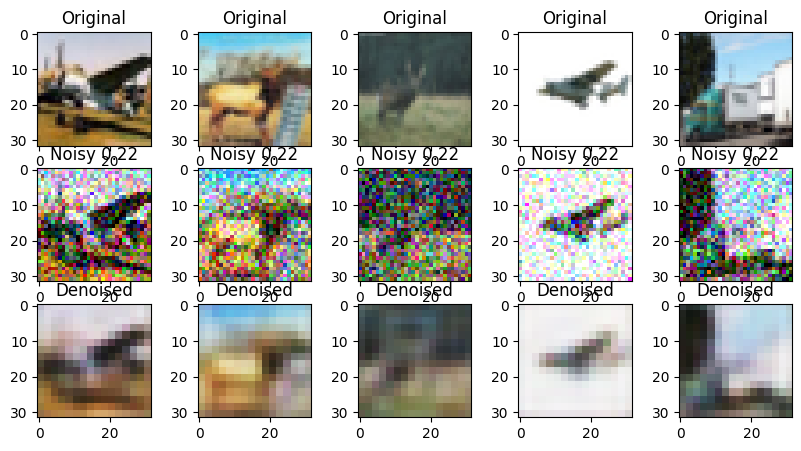

Epoch 2, Train Loss: 0.0090, Test Loss: 0.0084
Epoch 3, Train Loss: 0.0083, Test Loss: 0.0080
Epoch 4, Train Loss: 0.0080, Test Loss: 0.0082
Epoch 5, Train Loss: 0.0079, Test Loss: 0.0075


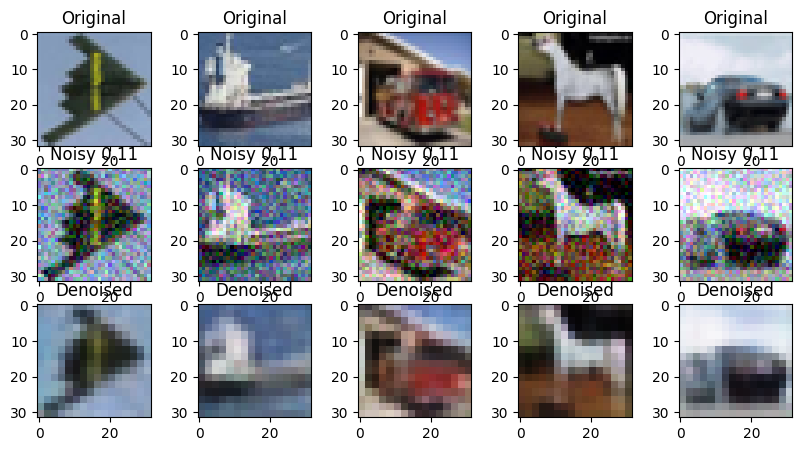

Epoch 6, Train Loss: 0.0076, Test Loss: 0.0075
Epoch 7, Train Loss: 0.0075, Test Loss: 0.0074
Epoch 8, Train Loss: 0.0074, Test Loss: 0.0073
Epoch 9, Train Loss: 0.0072, Test Loss: 0.0072
Epoch 10, Train Loss: 0.0073, Test Loss: 0.0072


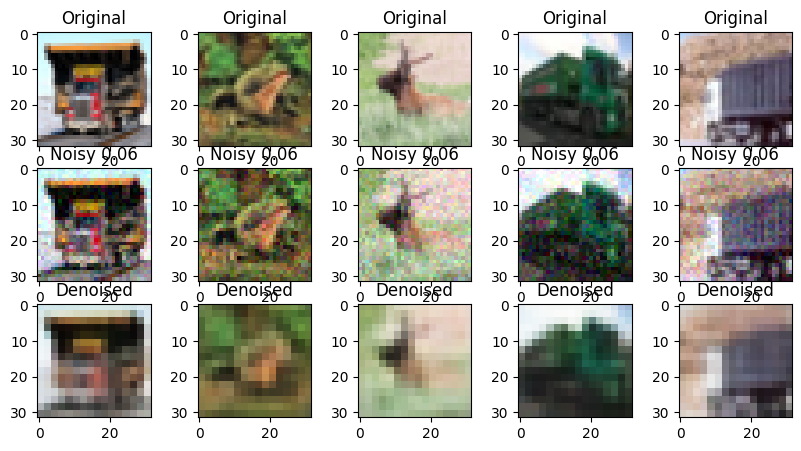

In [51]:
train_loss_dae = []
test_loss_dae = []

for epoch in range(epochs):
    dae.train()
    train_loss = 0.0
    for images, _ in other_train_loader:
        images = images.to(device)
        noise_factor = np.random.uniform(0.03, 0.3)
        noisy_images = add_noise(images, noise_factor=noise_factor)
        outputs = dae(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(other_train_loader)
    train_loss_dae.append(avg_train_loss)

    dae.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, _ in other_test_loader:
            images = images.to(device)
            noise_factor = np.random.uniform(0.03, 0.3)
            noisy_images = add_noise(images, noise_factor=noise_factor)
            outputs = dae(noisy_images)
            loss = criterion(outputs, images)

            test_loss += loss.item()

    avg_test_loss = test_loss / len(other_test_loader)
    test_loss_dae.append(avg_test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    if epoch == 0 or (epoch + 1) % 5 == 0:
        visualize_output_dae(dae, other_train_loader, device)

**Observation:** 
- After 10 epochs the denoising autoencoder stagnates
- Afterwards in the fine-tuning task of the CNN we had generally better and more consistent better results when stopping the denoising Autoencoder after 10 epochs

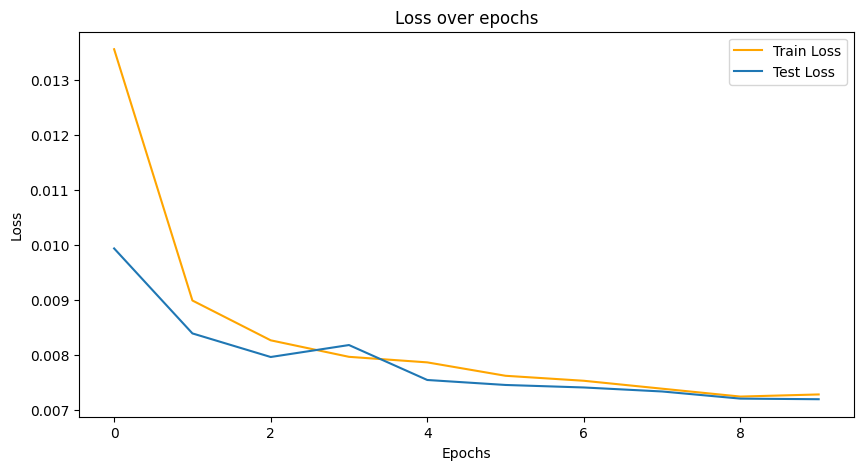

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_dae, label='Train Loss', color='orange')
plt.plot(test_loss_dae, label='Test Loss')
plt.title("Loss over epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

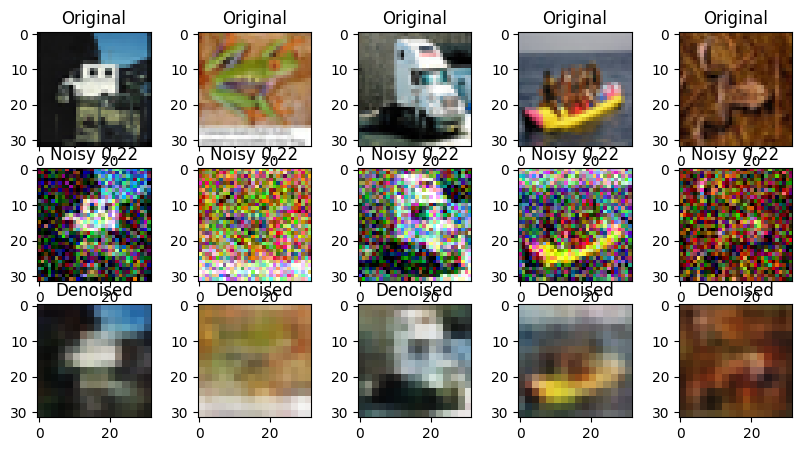

In [53]:
# visualize the denoising autoencoder output on test data
visualize_output_dae(dae, other_test_loader, device)

# 4. Finetuned CNN on pretrained DenoisingAutoencoder

**Task 3:** Fine-tune the pre-trained model to discriminate cats and dogs

**Observation after experimenting a little with different parameters**
- With 10 epochs, fluctuation of accuracy in validation set was huge. Especially with freezed model between 63% and 73%, unfreezed model was more consistent
-  Best and consistent results with 15 epochs, which is more epochs more than the BasicCNN with 10
- It has also consistent worse accuracy in the validation set with an average 71% (+- 2%) in comparison to the BasicCNN with an average of 76% (+-1%)
- Generally unfreezed model has consistent better accuracy in the testing set than the freezed model

**More accurate experimenting at the end**

In [58]:
class FineTunedCNN(nn.Module):
    def __init__(self, pretrained_autoencoder, freeze):
        super(FineTunedCNN, self).__init__()

        # Transfer learning / fine-tuning by using the encoder of the Denoising Autoencoder        
        self.encoder = pretrained_autoencoder.encoder
        
        # Optionally freeze the encoder weights
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False 

        # Use own classifier on top of the encoder
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

### Freezed Model ###
fine_tuned_model_freeze = FineTunedCNN(dae, True).to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(fine_tuned_model_freeze.parameters(), lr=lr)
epochs = 15

print("Fine-tuning the freezed model...")
train_model(fine_tuned_model_freeze, train_loader_cats_dogs, criterion, optimizer, epochs, device=device)

print()
print("Evaluating the freezed fine-tuned model...")
evaluate_model(fine_tuned_model_freeze, test_loader_cats_dogs, device=device)

### Unfreezed Model ###
fine_tuned_model_unfreeze = FineTunedCNN(dae, False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fine_tuned_model_unfreeze.parameters(), lr=lr)

print()
print("Fine-tuning the unfreezed model...")
train_model(fine_tuned_model_unfreeze, train_loader_cats_dogs, criterion, optimizer, epochs, device=device)

print()
print("Evaluating the unfreezed fine-tuned model...")
evaluate_model(fine_tuned_model_unfreeze, test_loader_cats_dogs, device=device)

Fine-tuning the freezed model...
Epoch 1/15, Loss: 0.6774089996981772, Accuracy: 58.91%
Epoch 2/15, Loss: 0.6364072584042884, Accuracy: 64.8%
Epoch 3/15, Loss: 0.6143666412799981, Accuracy: 67.05%
Epoch 4/15, Loss: 0.6036089265802104, Accuracy: 68.01%
Epoch 5/15, Loss: 0.5885794718933713, Accuracy: 69.56%
Epoch 6/15, Loss: 0.5793627521414666, Accuracy: 70.14%
Epoch 7/15, Loss: 0.5751702421030421, Accuracy: 70.63%
Epoch 8/15, Loss: 0.5577335031169235, Accuracy: 71.67%
Epoch 9/15, Loss: 0.5520312264087094, Accuracy: 72.02%
Epoch 10/15, Loss: 0.5412941594032725, Accuracy: 73.21%
Epoch 11/15, Loss: 0.534454835068648, Accuracy: 73.77%
Epoch 12/15, Loss: 0.5303963341151073, Accuracy: 73.99%
Epoch 13/15, Loss: 0.5315429403144083, Accuracy: 73.9%
Epoch 14/15, Loss: 0.5197875957200482, Accuracy: 74.48%
Epoch 15/15, Loss: 0.5127295523312441, Accuracy: 75.34%

Evaluating the freezed fine-tuned model...
Accuracy: 70.95%

Fine-tuning the unfreezed model...
Epoch 1/15, Loss: 0.6565345415643825, Accu

71.3

# 5. Experiment with the amount of fine-tuning data and the number of training steps
- Experiments are run 10 times for more reliable results and the averages are shown
- Experiments results are shown first for better overview. Code for every experiment are appended at the end

## 5.1 Experiment with number of training steps
- Generally hard to compare because the results fluctuate a lot, and small architecture because of the small dataset and relatively easy task
- Take the testing accuracy for performance measure

- Freezed Model

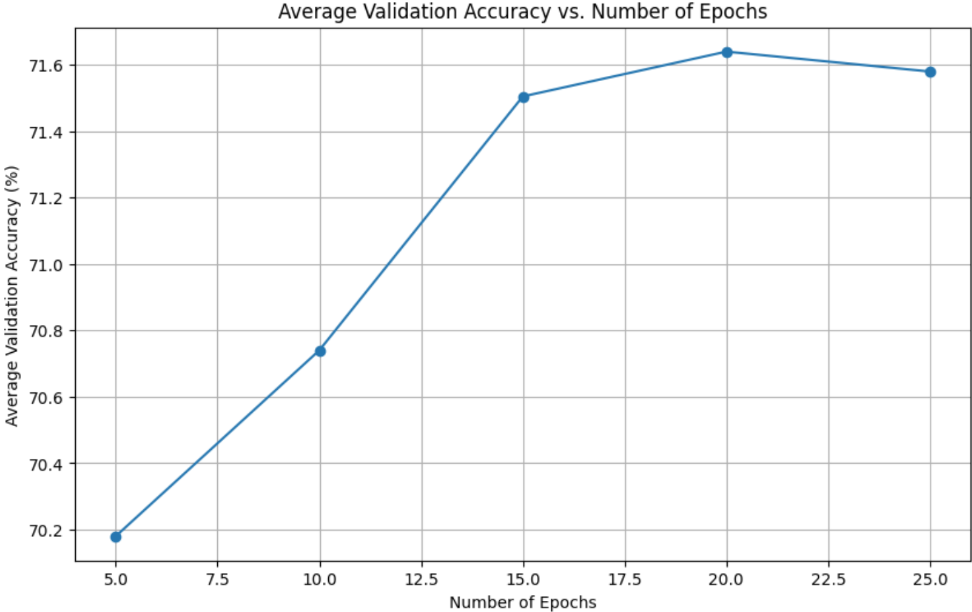

- Unfreezed Model

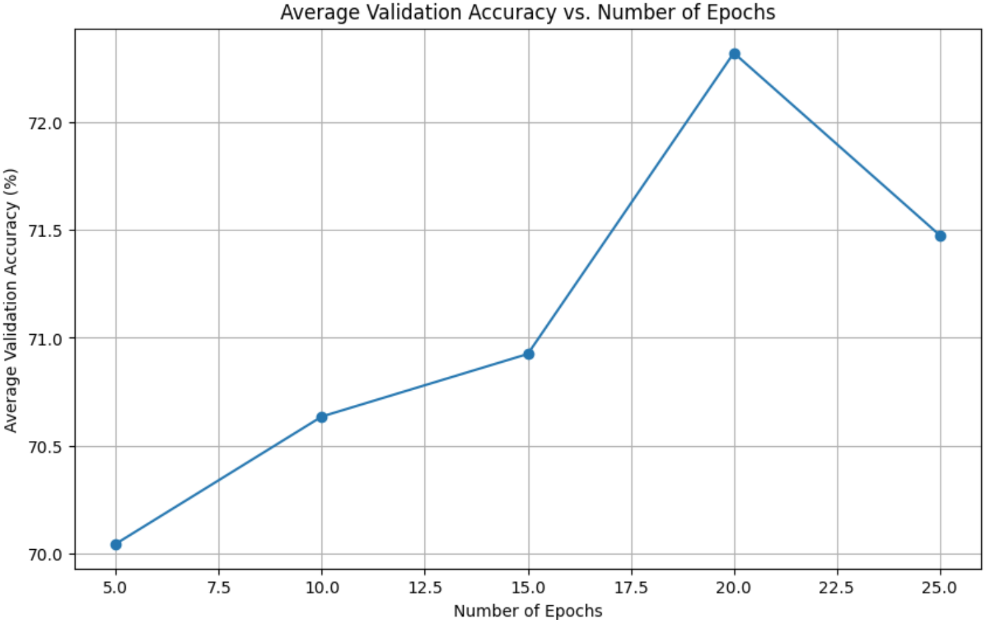

**Observation of training steps**
- In unfreezed and freezed model epochs=20 had the best results, larger difference with the unfreezed model
- Unfreezed model performed better with 72.32% accuracy in the testing set, compared to 71.64% of the freezed model
- Noteworthy: 
  - Freezed model had after 15 epochs similar testing accuracy as the 20 and 25 epochs. 
  - Freezed model performed with less epochs better than the unfreezed model. The freezed model with 15 epochs around 71.5% compared to 70.9% of the unfreezed model. But the freezed model has best results with enough training steps 
  - The difference is due the fact, that the freezed model has less parameters to tune, so less training steps (time) necessary. But the unfreezed can fine tune more with enough training 


## 5.2 Experiment with the amount of fine-tuning data
- In the following as parameter configuration epochs=20 is chosen because it had performed the best
- Experiment is done with freezed and unfreezed model to check differences between the amount of data both models need

- freezed model

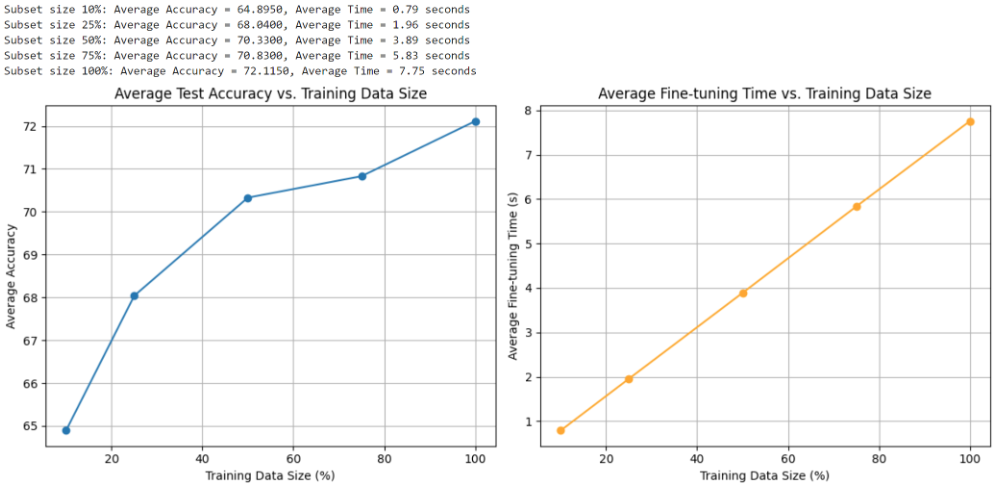

- unfreezed model

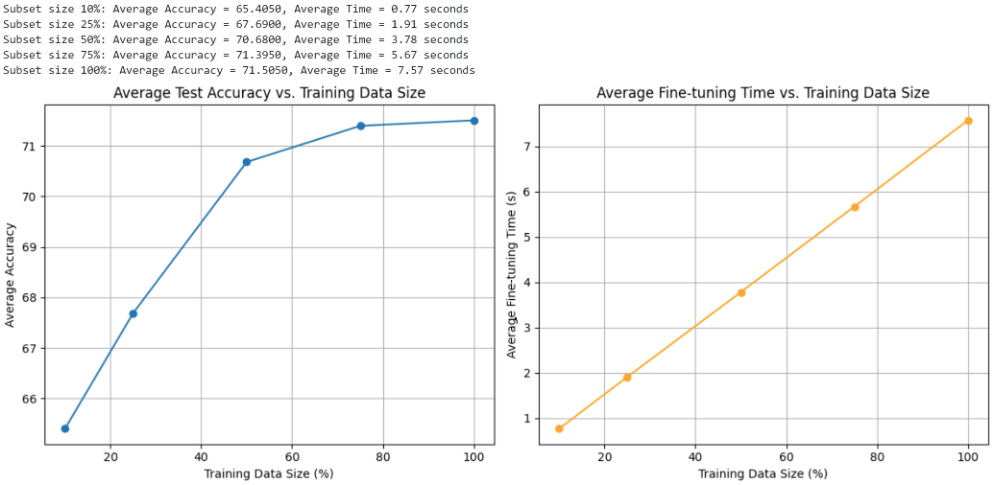

**Observation**
- Training time across different amount of data is linear for both models

- The performance is similar to the one of the BasicCNN with around 76% (+-2%) trained at the beginning. But nevertheless worse with an average of 72.1% with the freezed model and 71.5% with the unfreezed model 

- The trend is that a subset of the data leads to similar performance compared the whole dataset size of 100%
  - Freezed model: Not prominent there. But with 50% of the data then performs similar good than with 100% 
  - Unfreezed model: This effect is surprisingly prominent shown there, where 50% of the data leads to almost the same average accuracy as 100% of the data, suggesting faster convergence

- Noteworthy: The unfreezed model has a bigger parameter space but performs similar good with a subset of the data than the freezed model. Generally if small dataset to fine tune on and bigger pretrained model is used than freezing the pretrained model is ideal, because the number of data points should be ideally multiple times bigger than the parameter space to fine tune on

# Code for experimenting training steps

In [81]:
def plot_results(avg_results):
    epochs = list(avg_results.keys())
    accuracies = list(avg_results.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracies, marker='o')
    plt.title('Average Validation Accuracy vs. Number of Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Average Validation Accuracy (%)')
    plt.grid(True)
    plt.show()

In [82]:
def run_experiment(train_loader, test_loader_cats_dogs, epochs_list, iterations=10, freeze=True, lr=0.001):
    results = {epoch: [] for epoch in epochs_list}
    
    for epoch in epochs_list:
        for _ in range(iterations):
            fine_tuned_model = FineTunedCNN(dae, freeze).to(device)
            optimizer = optim.Adam(fine_tuned_model.parameters(), lr=lr)
            train_model(fine_tuned_model, train_loader, criterion, optimizer, epochs=epoch, device=device) 
            print()

            print(f"Evaluating model fine-tuned with \n")
            test_accuracy = evaluate_model(fine_tuned_model, test_loader_cats_dogs, device=device)
            print()
            results[epoch].append(test_accuracy)
    
    avg_results = {epoch: np.mean(results[epoch]) for epoch in epochs_list}
    return avg_results

Epoch 1/5, Loss: 0.6543687684520795, Accuracy: 61.68%
Epoch 2/5, Loss: 0.6008636364891271, Accuracy: 67.37%
Epoch 3/5, Loss: 0.5869545281692675, Accuracy: 67.8%
Epoch 4/5, Loss: 0.5827651692044203, Accuracy: 68.92%
Epoch 5/5, Loss: 0.5556912126055189, Accuracy: 70.72%

Evaluating model fine-tuned with 100% of the data... 

Accuracy: 70.60%

Epoch 1/5, Loss: 0.657143068541387, Accuracy: 61.13%
Epoch 2/5, Loss: 0.605091817060094, Accuracy: 66.26%
Epoch 3/5, Loss: 0.5927218016545484, Accuracy: 67.64%
Epoch 4/5, Loss: 0.5687956396181872, Accuracy: 70.1%
Epoch 5/5, Loss: 0.5500732362270355, Accuracy: 71.86%

Evaluating model fine-tuned with 100% of the data... 

Accuracy: 69.35%

Epoch 1/5, Loss: 0.6626332956514541, Accuracy: 60.15%
Epoch 2/5, Loss: 0.6103806712065533, Accuracy: 65.89%
Epoch 3/5, Loss: 0.5807042423706905, Accuracy: 69.16%
Epoch 4/5, Loss: 0.5690426530352064, Accuracy: 70.13%
Epoch 5/5, Loss: 0.5598947170433725, Accuracy: 70.68%

Evaluating model fine-tuned with 100% of the 

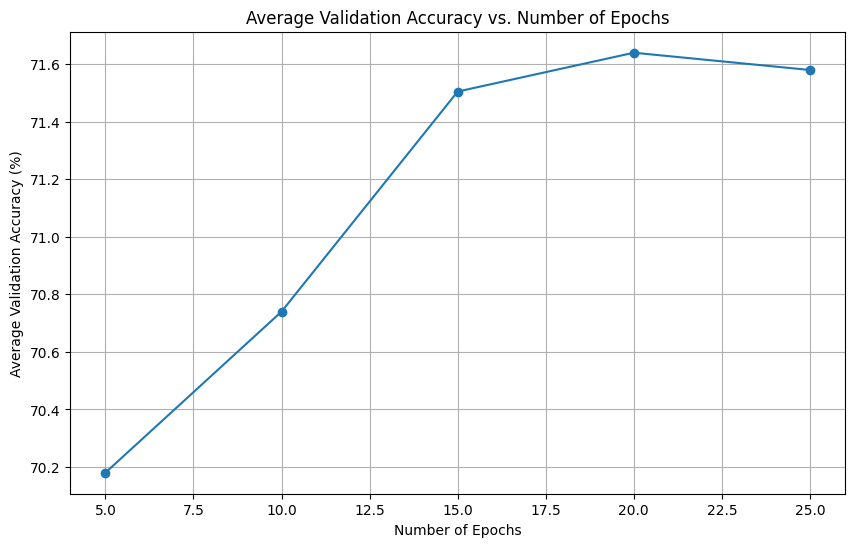

In [79]:
lr = 0.001

# Define the list of epochs to experiment with
epochs_list = [5, 10, 15, 20, 25]

subset_ratios = [0.1, 0.25, 0.5, 0.75, 1.0]

# Number of runs
num_runs = 10
                 
### Run the experiment with freezed model ### 
avg_results = run_experiment(train_loader_cats_dogs, test_loader_cats_dogs, epochs_list, iterations=num_runs, freeze=True, lr=lr)

# Print the results
for epoch, avg_accuracy in avg_results.items():
    print(f"Epochs: {epoch}, Average Validation Accuracy: {avg_accuracy:.2f}%")

plot_results(avg_results)

### Run different number of training steps with unfreezed model

Epoch 1/5, Loss: 0.6499612733816645, Accuracy: 62.07%
Epoch 2/5, Loss: 0.6047856044617428, Accuracy: 66.96%
Epoch 3/5, Loss: 0.5843483222897645, Accuracy: 68.76%
Epoch 4/5, Loss: 0.5584715371298942, Accuracy: 70.7%
Epoch 5/5, Loss: 0.5514502715153299, Accuracy: 71.43%

Evaluating model fine-tuned with 100% of the data... 

Accuracy: 70.70%

Epoch 1/5, Loss: 0.6602195038157663, Accuracy: 60.89%
Epoch 2/5, Loss: 0.6129340237113321, Accuracy: 65.8%
Epoch 3/5, Loss: 0.5886037209231383, Accuracy: 68.51%
Epoch 4/5, Loss: 0.5690016532020205, Accuracy: 70.25%
Epoch 5/5, Loss: 0.5644903670830331, Accuracy: 70.53%

Evaluating model fine-tuned with 100% of the data... 

Accuracy: 68.30%

Epoch 1/5, Loss: 0.688403615526333, Accuracy: 57.36%
Epoch 2/5, Loss: 0.6546622245175064, Accuracy: 64.17%
Epoch 3/5, Loss: 0.6293206287037795, Accuracy: 66.98%
Epoch 4/5, Loss: 0.6127141121846096, Accuracy: 67.93%
Epoch 5/5, Loss: 0.5973748336931702, Accuracy: 69.27%

Evaluating model fine-tuned with 100% of the

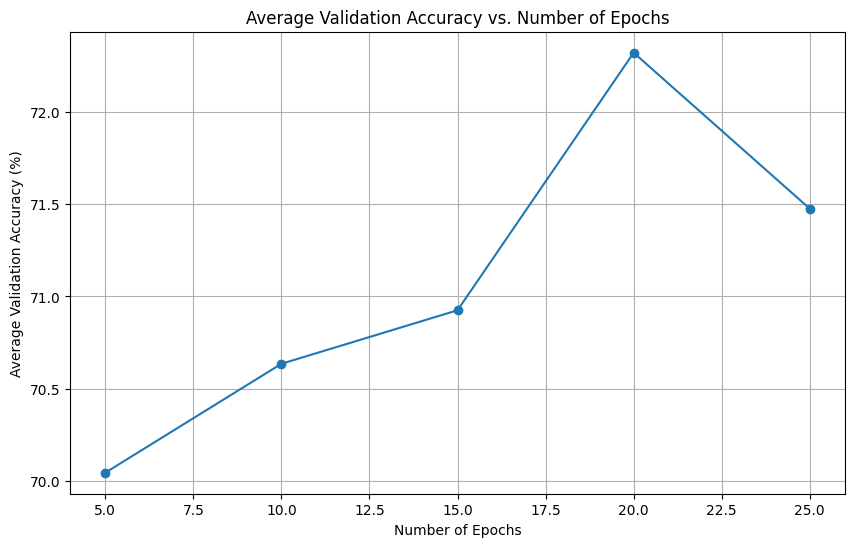

In [83]:
### Run the experiment with unfreezed model ### 
avg_results = run_experiment(train_loader_cats_dogs, test_loader_cats_dogs, epochs_list, freeze=False, lr=lr)

# Print the results
for epoch, avg_accuracy in avg_results.items():
    print(f"Epochs: {epoch}, Average Validation Accuracy: {avg_accuracy:.2f}%")

plot_results(avg_results)

# Code for experiment with the amount of fine-tuning data

### Freezed

Run 1/10
Fine-tuning with 10% of the data...
Epoch 1/20, Loss: 0.7200609482824802, Accuracy: 53.1%
Epoch 2/20, Loss: 0.6924847550690174, Accuracy: 54.1%
Epoch 3/20, Loss: 0.6827170476317406, Accuracy: 58.2%
Epoch 4/20, Loss: 0.6751886643469334, Accuracy: 58.5%
Epoch 5/20, Loss: 0.6654558964073658, Accuracy: 59.4%
Epoch 6/20, Loss: 0.6516000032424927, Accuracy: 64.7%
Epoch 7/20, Loss: 0.6436729431152344, Accuracy: 64.6%
Epoch 8/20, Loss: 0.6401297897100449, Accuracy: 66.1%
Epoch 9/20, Loss: 0.6240432374179363, Accuracy: 65.9%
Epoch 10/20, Loss: 0.6146061979234219, Accuracy: 68.0%
Epoch 11/20, Loss: 0.6116961054503918, Accuracy: 69.3%
Epoch 12/20, Loss: 0.6004875302314758, Accuracy: 69.7%
Epoch 13/20, Loss: 0.5889358371496201, Accuracy: 71.9%
Epoch 14/20, Loss: 0.5775014571845531, Accuracy: 71.1%
Epoch 15/20, Loss: 0.5702146291732788, Accuracy: 72.5%
Epoch 16/20, Loss: 0.5638971477746964, Accuracy: 72.1%
Epoch 17/20, Loss: 0.5493769273161888, Accuracy: 75.0%
Epoch 18/20, Loss: 0.54003867

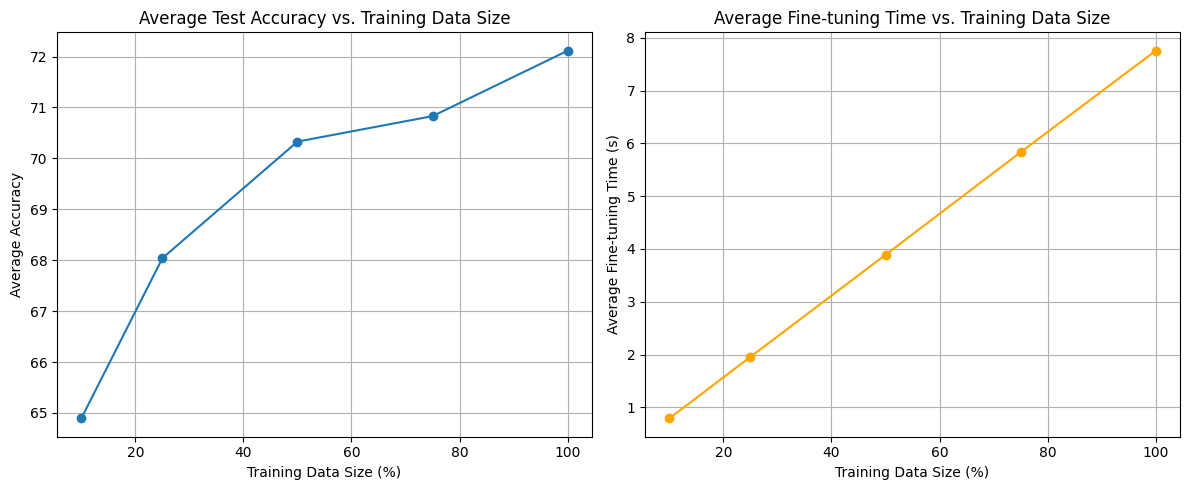

In [90]:
# Number of runs
num_runs = 10

# Subset ratios to use for fine-tuning
subset_ratios = [0.1, 0.25, 0.5, 0.75, 1.0]
subset_loaders = []

lr = 0.001
epochs = 20

# Create a subset of the training data
for ratio in subset_ratios:
    subset_size = int(len(train_cats_dogs) * ratio)
    subset, _ = random_split(train_cats_dogs, [subset_size, len(train_cats_dogs) - subset_size])
    subset_loader = DataLoader(subset, batch_size=64, shuffle=True)
    subset_loaders.append(subset_loader)

# Initialize results dictionary to store results of each run
all_results = {int(ratio * 100): {"accuracies": [], "times": []} for ratio in subset_ratios}

# Run the fine-tuning process 10 times
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    for i, loader in enumerate(subset_loaders):
        print(f"Fine-tuning with {int(subset_ratios[i] * 100)}% of the data...")
        fine_tuned_model = FineTunedCNN(dae, True).to(device)
        optimizer = optim.Adam(fine_tuned_model.parameters(), lr=lr)

        start_time = time.time()  # Start time for training
        train_model(fine_tuned_model, loader, criterion, optimizer, epochs=epochs, device=device)
        print("\n")
        elapsed_time = time.time() - start_time

        # Evaluate performance
        print(f"Evaluating model fine-tuned with {int(subset_ratios[i] * 100)}% of the data... \n")
        test_accuracy = evaluate_model(fine_tuned_model, test_loader_cats_dogs, device=device)
        all_results[int(subset_ratios[i] * 100)]["accuracies"].append(test_accuracy)
        all_results[int(subset_ratios[i] * 100)]["times"].append(elapsed_time)

# Calculate average results
average_results = {size: {"accuracy": np.mean(all_results[size]["accuracies"]),
                          "time": np.mean(all_results[size]["times"])}
                   for size in all_results}

# Print average results
for size in average_results:
    print(f"Subset size {size}%: Average Accuracy = {average_results[size]['accuracy']:.4f}, Average Time = {average_results[size]['time']:.2f} seconds")

subset_sizes = list(average_results.keys())
average_accuracies = [average_results[size]["accuracy"] for size in subset_sizes]
average_times = [average_results[size]["time"] for size in subset_sizes]

plt.figure(figsize=(12, 5))

# Plot average accuracy
plt.subplot(1, 2, 1)
plt.plot(subset_sizes, average_accuracies, marker="o")
plt.xlabel("Training Data Size (%)")
plt.ylabel("Average Accuracy")
plt.title("Average Test Accuracy vs. Training Data Size")
plt.grid()

# Plot average time
plt.subplot(1, 2, 2)
plt.plot(subset_sizes, average_times, marker="o", color="orange")
plt.xlabel("Training Data Size (%)")
plt.ylabel("Average Fine-tuning Time (s)")
plt.title("Average Fine-tuning Time vs. Training Data Size")
plt.grid()

plt.tight_layout()
plt.show()

### Unfreezed

Run 1/10
Fine-tuning with 10% of the data...
Epoch 1/20, Loss: 0.6930068470537663, Accuracy: 55.7%
Epoch 2/20, Loss: 0.6560967490077019, Accuracy: 63.4%
Epoch 3/20, Loss: 0.621342558413744, Accuracy: 65.6%
Epoch 4/20, Loss: 0.6039990670979023, Accuracy: 66.9%
Epoch 5/20, Loss: 0.5855920650064945, Accuracy: 68.3%
Epoch 6/20, Loss: 0.5700858272612095, Accuracy: 69.7%
Epoch 7/20, Loss: 0.5406816136091948, Accuracy: 73.2%
Epoch 8/20, Loss: 0.5309550799429417, Accuracy: 72.9%
Epoch 9/20, Loss: 0.49745194241404533, Accuracy: 76.3%
Epoch 10/20, Loss: 0.48773350194096565, Accuracy: 75.9%
Epoch 11/20, Loss: 0.47205549478530884, Accuracy: 78.9%
Epoch 12/20, Loss: 0.4440959431231022, Accuracy: 80.4%
Epoch 13/20, Loss: 0.4325349945574999, Accuracy: 79.6%
Epoch 14/20, Loss: 0.42413639836013317, Accuracy: 81.0%
Epoch 15/20, Loss: 0.4236403666436672, Accuracy: 80.2%
Epoch 16/20, Loss: 0.3731412459164858, Accuracy: 84.2%
Epoch 17/20, Loss: 0.3744843676686287, Accuracy: 84.1%
Epoch 18/20, Loss: 0.38160

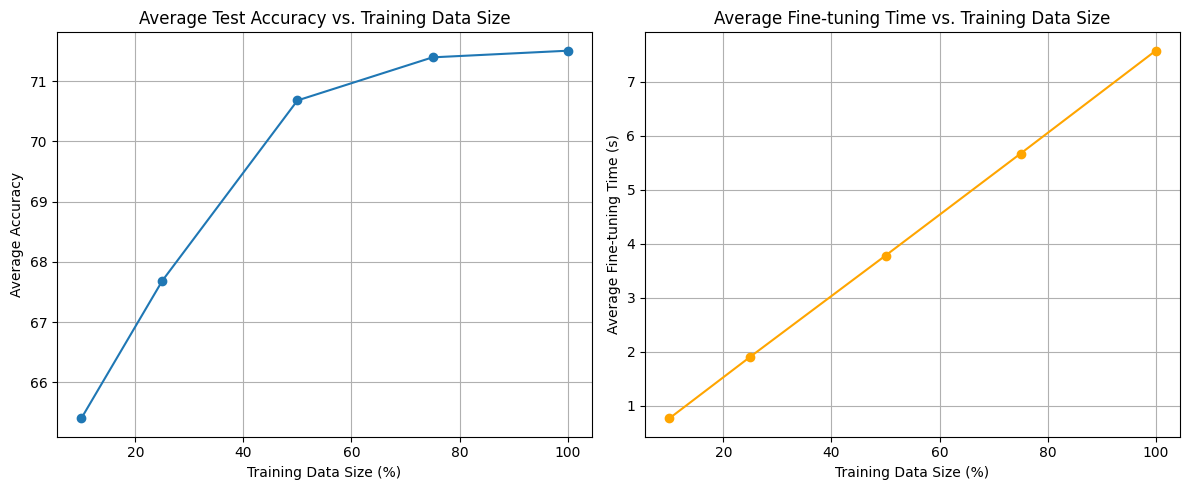

In [89]:
# Number of runs
num_runs = 10

# Subset ratios to use for fine-tuning
subset_ratios = [0.1, 0.25, 0.5, 0.75, 1.0]
subset_loaders = []

lr = 0.001
epochs = 20

# Create a subset of the training data
for ratio in subset_ratios:
    subset_size = int(len(train_cats_dogs) * ratio)
    subset, _ = random_split(train_cats_dogs, [subset_size, len(train_cats_dogs) - subset_size])
    subset_loader = DataLoader(subset, batch_size=64, shuffle=True)
    subset_loaders.append(subset_loader)

# Initialize results dictionary to store results of each run
all_results = {int(ratio * 100): {"accuracies": [], "times": []} for ratio in subset_ratios}

# Run the fine-tuning process 10 times
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    for i, loader in enumerate(subset_loaders):
        print(f"Fine-tuning with {int(subset_ratios[i] * 100)}% of the data...")
        fine_tuned_model = FineTunedCNN(dae, False).to(device)
        optimizer = optim.Adam(fine_tuned_model.parameters(), lr=lr)

        start_time = time.time()  # Start time for training
        train_model(fine_tuned_model, loader, criterion, optimizer, epochs=epochs, device=device)
        print("\n")
        elapsed_time = time.time() - start_time

        # Evaluate performance
        print(f"Evaluating model fine-tuned with {int(subset_ratios[i] * 100)}% of the data... \n")
        test_accuracy = evaluate_model(fine_tuned_model, test_loader_cats_dogs, device=device)
        all_results[int(subset_ratios[i] * 100)]["accuracies"].append(test_accuracy)
        all_results[int(subset_ratios[i] * 100)]["times"].append(elapsed_time)

# Calculate average results
average_results = {size: {"accuracy": np.mean(all_results[size]["accuracies"]),
                          "time": np.mean(all_results[size]["times"])}
                   for size in all_results}

# Print average results
for size in average_results:
    print(f"Subset size {size}%: Average Accuracy = {average_results[size]['accuracy']:.4f}, Average Time = {average_results[size]['time']:.2f} seconds")

subset_sizes = list(average_results.keys())
average_accuracies = [average_results[size]["accuracy"] for size in subset_sizes]
average_times = [average_results[size]["time"] for size in subset_sizes]

plt.figure(figsize=(12, 5))

# Plot average accuracy
plt.subplot(1, 2, 1)
plt.plot(subset_sizes, average_accuracies, marker="o")
plt.xlabel("Training Data Size (%)")
plt.ylabel("Average Accuracy")
plt.title("Average Test Accuracy vs. Training Data Size")
plt.grid()

# Plot average time
plt.subplot(1, 2, 2)
plt.plot(subset_sizes, average_times, marker="o", color="orange")
plt.xlabel("Training Data Size (%)")
plt.ylabel("Average Fine-tuning Time (s)")
plt.title("Average Fine-tuning Time vs. Training Data Size")
plt.grid()

plt.tight_layout()
plt.show()